In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score

Пример без лагов

In [30]:
# Создаем синтетические данные
np.random.seed(50)
n_samples = 10000

# Рейтинги (пример порядка)
ratings = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC', 'D']
company_types = ['bank', 'oil', 'tech', 'retail', 'telecom']

data = pd.DataFrame({
    'rating': np.random.choice(ratings, size=n_samples),
    'date': pd.date_range(start='2020-01-01', periods=n_samples, freq='D'),
    'company_type': np.random.choice(company_types, size=n_samples),
    'inn': np.random.randint(1000,2000, size=n_samples)  # просто случайные ИНН
})

In [32]:
# ① Кодируем рейтинг (ординально, если есть порядок)
rating_order = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC', 'D']  # от лучшего к худшему
encoder = OrdinalEncoder(categories=[rating_order])
data['rating_encoded'] = encoder.fit_transform(data[['rating']])

# ② Временные фичи
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek

# ③ Категориальные фичи (One-Hot для типа компании)
data = pd.get_dummies(data, columns=['company_type'])

# ④ Агрегаты по ИНН (пример: сколько раз встречается компания)
data['inn_count'] = data.groupby('inn')['inn'].transform('count')

# Удаляем ненужные столбцы
data = data.drop(['inn', 'date'], axis=1)

In [34]:
# Фичи и целевая переменная
X = data.drop(['rating', 'rating_encoded'], axis=1)
y = data['rating_encoded']

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Оценка
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=rating_order))

Accuracy: 0.11
              precision    recall  f1-score   support

         AAA       0.10      0.11      0.11       298
         AA+       0.11      0.12      0.11       310
          AA       0.17      0.15      0.16       337
         BBB       0.14      0.13      0.13       372
         BB+       0.12      0.13      0.13       344
          BB       0.08      0.08      0.08       346
           B       0.09      0.10      0.10       317
         CCC       0.11      0.10      0.10       347
           D       0.11      0.10      0.10       329

    accuracy                           0.11      3000
   macro avg       0.11      0.11      0.11      3000
weighted avg       0.11      0.11      0.11      3000



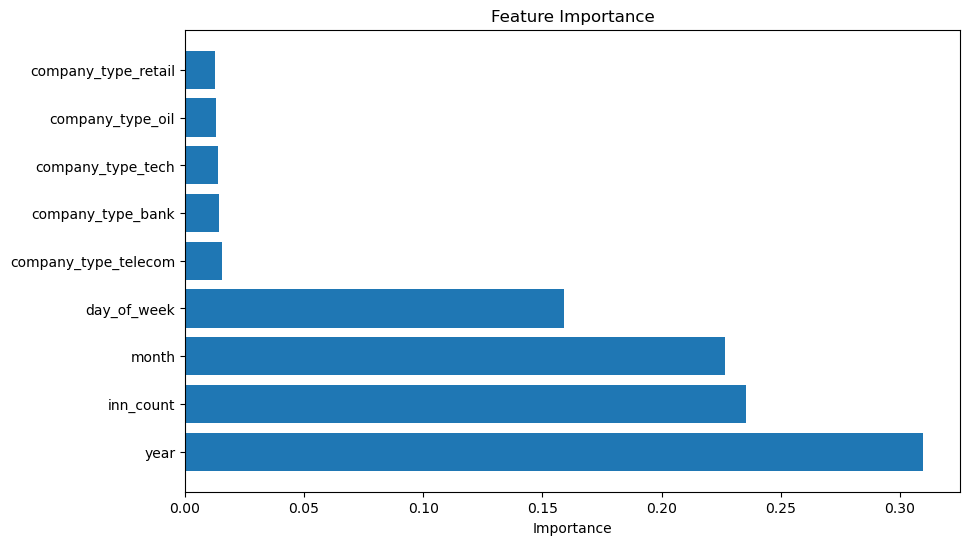

In [35]:
import matplotlib.pyplot as plt

# Важность фичей
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# График
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

Пример с лагами

In [39]:
np.random.seed(42)
n_companies = 500  # 50 компаний
n_months = 24     # 2 года данных (24 месяца)
n_samples = 10000
ratings = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC']
data = pd.DataFrame({
    'inn': np.random.randint(1000,2000, size=n_samples),
    'date': pd.date_range(start='2020-01-01', periods=n_months, freq='ME').tolist() * n_companies,
    'rating': np.random.choice(ratings, size=n_companies * n_months, p=[0.1, 0.2, 0.3, 0.2, 0.1, 0.05, 0.03, 0.02])
})
print(data['inn'].unique())

ValueError: All arrays must be of the same length

In [41]:
np.random.seed(42)
n_companies = 5000
n_months = 24
ratings = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC']
rating_probs = [0.1, 0.15, 0.15, 0.15, 0.1, 0.1, 0.15, 0.1]

# Создаем компании с разными характеристиками
companies = pd.DataFrame({
    'inn': np.random.randint(1000, 2000, size=n_companies),
    'company_type': np.random.choice(['bank', 'oil', 'tech', 'retail', 'manufacturing'], size=n_companies),
    'base_rating': np.random.choice(ratings, size=n_companies, p=rating_probs)
})

# Генерируем временные ряды для каждой компании
data = []
for _, company in companies.iterrows():
    dates = pd.date_range(start='2020-01-01', periods=n_months, freq='ME')
    base_rating_idx = ratings.index(company['base_rating'])
    
    # Генерируем рейтинги с некоторой динамикой
    rating_idxs = np.clip(
        base_rating_idx + np.cumsum(np.random.normal(0, 0.3, n_months)).round().astype(int),
        0, len(ratings)-1
    )
    company_ratings = [ratings[i] for i in rating_idxs]
    
    data.extend([{
        'inn': company['inn'],
        'date': date,
        # 'company_type': company['company_type'],
        'rating': rating,
        'months_since_start': i
    } for i, (date, rating) in enumerate(zip(dates, company_ratings))])

data = pd.DataFrame(data)

In [42]:
# ② Временные фичи
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek

# # ③ Категориальные фичи (One-Hot для типа компании)
# data = pd.get_dummies(data, columns=['company_type'])

# ④ Агрегаты по ИНН (пример: сколько раз встречается компания)
data['inn_count'] = data.groupby('inn')['inn'].transform('count')


In [58]:
# --- 2. Добавляем лаги рейтинга ---
data = data.sort_values(['inn', 'date'])

for lag in [1, 3, 6, 12]:
    data[f'rating_lag_{lag}'] = data.groupby('inn')['rating'].shift(lag)

# Удаляем строки с NaN (где нет истории)
data = data.dropna()


In [60]:
# --- 3. Правильное кодирование ---
# Создаем словарь для ручного кодирования
rating_to_code = {rating: i for i, rating in enumerate(rating_order)}

# Применяем кодирование ко всем столбцам с рейтингами
data['rating_encoded'] = data['rating'].map(rating_to_code)
for lag in [1, 3, 6, 12]:
    col = f'rating_lag_{lag}'
    data[col] = data[col].map(rating_to_code)
# Разница с предыдущим рейтингом
data['rating_diff_1'] = data.groupby('inn')['rating_encoded'].diff(1).fillna(0)
data['rating_diff_2'] = data.groupby('inn')['rating_encoded'].diff(2).fillna(0)
data['rating_diff_3'] = data.groupby('inn')['rating_encoded'].diff(3).fillna(0)
print(data['rating_diff_1'].unique())
print(data['rating_diff_2'].unique())
print(data['rating_diff_3'].unique())

[ 0. -1.  3.  2. -3. -2.  4.  1.  7. -4.  5. -6. -5.  6. -7.]
[ 0. -1.  2.  5. -3. -2.  1.  4.  3. -5.  6. -4. -6. -7.  7.]
[ 0. -2.  2.  4. -1. -5.  3.  5. -6.  1.  6. -4. -3. -7.  7.]


In [62]:
data.dropna()

,inn,date,rating,months_since_start,year,month,day_of_week,inn_count,rating_encoded,rating_diff_1,rating_diff_2,rating_diff_3,rating_lag_1,rating_lag_3,rating_lag_6,rating_lag_12
38041,1000,2020-02-29,BBB,1,2020,2,5,216,3,0.0,0.0,0.0,1,3,1,3
66241,1000,2020-02-29,AA,1,2020,2,5,216,2,-1.0,0.0,0.0,3,3,4,3
68137,1000,2020-02-29,AA,1,2020,2,5,216,2,0.0,-1.0,0.0,2,1,6,1
101617,1000,2020-02-29,AA+,1,2020,2,5,216,1,-1.0,-1.0,-2.0,2,3,3,3
108265,1000,2020-02-29,BB+,1,2020,2,5,216,4,3.0,2.0,2.0,1,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89803,1999,2021-08-31,BBB,19,2021,8,1,24,3,1.0,1.0,1.0,2,2,2,1
89804,1999,2021-09-30,BBB,20,2021,9,3,24,3,0.0,1.0,1.0,3,2,2,2
89805,1999,2021-10-31,BBB,21,2021,10,6,24,3,0.0,0.0,1.0,3,2,2,2
89806,1999,2021-11-30,BBB,22,2021,11,1,24,3,0.0,0.0,0.0,3,3,2,2


In [64]:
# --- 4. Фичи и обучение ---
# X = data.filter(like='lag_')  # Только лаги
# y = data['rating_encoded']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = RandomForestClassifier(n_estimators=200, random_state=42)
# model.fit(X_train, y_train)
exclude_cols = ['inn', 'date', 'rating', 'rating_encoded']
X = data.drop(exclude_cols, axis=1)
y = data['rating_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 4. Обучение модели ---
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    # class_weight='balanced'  # Для несбалансированных данных
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [65]:
# --- 5. Оценка ---
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro'):.2f}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro'):.2f}")
print(f"F1 score: {f1_score(y_test, y_pred, average='micro'):.2f}")
# print(classification_report(y_test, y_pred, target_names=rating_order))

# Важность фичей
# pd.DataFrame({
#     'feature': X.columns,
#     'importance': model.feature_importances_
# }).sort_values('importance', ascending=False)

Accuracy: 0.94
Recall: 0.94
Precision: 0.94
F1 score: 0.94


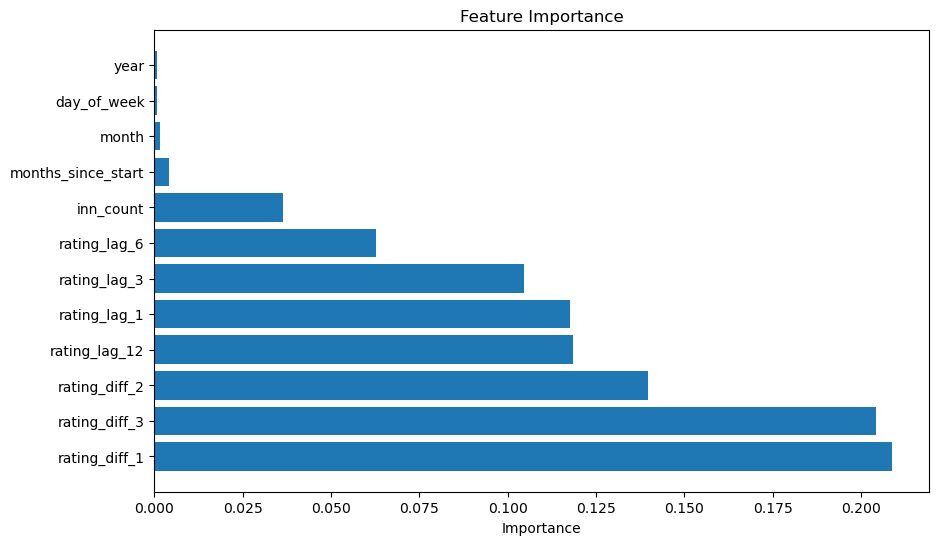

In [66]:
import matplotlib.pyplot as plt

# Важность фичей
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# График
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

А теперь на реальных данных с подуровнем

In [429]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [431]:
data = pd.read_excel("/Users/danilalipatov/PycharmProjects/diploma/resemple_data_cat_level_cat.xlsx")

In [432]:
inn = 'identifier'
date = 'resampled_dates'
num_ = 'resampled_values'
category = 'rating_category'
agency = 'agency'
_ro_type = '_ro_type'
current_agency = 'Expert_RA'
current_ro_type = 'BNFC - нефинансовая компания'
print(data["_ro_type"].unique())
print(len(data[inn].unique()))

['BNFC - нефинансовая компания' 'CBNK - кредитная организация'
 'FLSG - лизинговая компания (фирма)'
 'FOFO - прочие финансовые организации, в том числе специализированные общества'
 'CO - прочий вид организации' 'FNPF - негосударственный пенсионный фонд'
 'FINS - страховая организация'
 'BNFH - холдинговая компания (нефинансовая)'
 'FMFO - микрофинансовая организация' 'FDEP - депозитарий'
 'FFCT - юридическое лицо, специализирующееся на предоставлении финансирования под уступку денежного требования (факторинговая компания)'
 'IFO - международная финансовая организация']
1302


In [433]:
# ручной фильтр
# data[(data[agency] == current_agency) & (data[_ro_type] == current_ro_type)]

In [448]:
# --- Предобработка ---
data[date] = pd.to_datetime(data[date])
data = data.sort_values([inn, date])

# Лаги
data['rating_diff_1'] = data.groupby(inn)[num_].diff(1).fillna(0)
data['rating_diff_2'] = data.groupby(inn)[num_].diff(2).fillna(0)
data['rating_diff_3'] = data.groupby(inn)[num_].diff(3).fillna(0)
data['rating_diff_4'] = data.groupby(inn)[num_].diff(4).fillna(0)
data['rating_diff_5'] = data.groupby(inn)[num_].diff(5).fillna(0)
data['rating_diff_6'] = data.groupby(inn)[num_].diff(6).fillna(0)
data['rating_diff_7'] = data.groupby(inn)[num_].diff(5).fillna(0)
data['rating_diff_8'] = data.groupby(inn)[num_].diff(6).fillna(0)
data['rating_diff_9'] = data.groupby(inn)[num_].diff(5).fillna(0)

for lag in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
# for lag in [12, 24, 36, 48]:
    data[f'rating_lag_{lag}'] = data.groupby(inn)[num_].shift(lag).dropna()
    print(f'rating_lag_{lag}')
print(data['rating_diff_1'].unique())
print(data['rating_diff_2'].unique())
print(data['rating_diff_3'].unique())
# Временные признаки
data['year'] = data[date].dt.year
data['month'] = data[date].dt.month
data['day_of_week'] = data[date].dt.dayofweek

# Метки
data['inn_count'] = data.groupby(inn)[inn].transform('count')

# Возраст компании
first_seen = data.groupby(inn)[date].transform('min')
data['company_age_months'] = ((data[date] - first_seen) / np.timedelta64(1, 'm')).astype(int)

# --- Подготовка признаков ---
categorical_features = [agency, _ro_type]
numerical_features = [
    'year', 'month', 'day_of_week',
    'inn_count', 'company_age_months', 
    'rating_diff_1', 'rating_diff_2', 'rating_diff_3', 'rating_diff_4', 'rating_diff_5', 'rating_diff_6',
    'rating_lag_1', 'rating_lag_2', 'rating_lag_3', 'rating_lag_4', 'rating_lag_5', 'rating_lag_6', 'rating_lag_7', 'rating_lag_8', 'rating_lag_9', 'rating_lag_10','rating_lag_11','rating_lag_12', 
    # 'rating_lag_12','rating_lag_24','rating_lag_36','rating_lag_48',
]

features = categorical_features + numerical_features
# features = numerical_features
# Удалим пропуски
data = data.dropna(subset=features + [num_])

X = data[features]
y = data[num_].astype(int)

rating_lag_1
rating_lag_2
rating_lag_3
rating_lag_4
rating_lag_5
rating_lag_6
rating_lag_7
rating_lag_8
rating_lag_9
rating_lag_10
rating_lag_11
rating_lag_12
[  0.   1.  -2.   2.  -1.   3.   7.   4.   5. -11.  -3.  11.   6.   8.
 -19. -10.  -8.  -7.  -9.   9.  -4.  10. -12.  12.  -6.  -5. -13.  13.
 -14.  14.  15. -18.]
[  0.   1.  -2.  -1.   3.   2.   7.   4.   5. -11.   9.  11.   6.  -3.
   8. -19. -10.  -8.  -7.  -9.  -4.  10. -12.  12.  -6.  -5. -13.  13.
 -14.  14.  15. -18.]
[  0.   1.  -2.   2.  -3.  -1.   3.   6.   7.   4.   5. -11.  11.   9.
   8. -19. -10.  -8.  -7.  -9.  -4.  10. -12.  12.  -6.  -5. -13.  13.
 -14. -15.  15. -18.]


In [450]:
len(data[inn].unique())

1176

In [452]:
# --- Pipeline ---
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', 'passthrough', numerical_features)
])
# preprocessor = ColumnTransformer([
#     ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
#     ('num', 'passthrough', numerical_features)
# ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200))
])

In [454]:
# --- Обучение ---
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
print(X_train.columns, y_train.name)
pipeline.fit(X_train, y_train)

Index(['agency', '_ro_type', 'year', 'month', 'day_of_week', 'inn_count',
       'company_age_months', 'rating_diff_1', 'rating_diff_2', 'rating_diff_3',
       'rating_diff_4', 'rating_diff_5', 'rating_diff_6', 'rating_lag_1',
       'rating_lag_2', 'rating_lag_3', 'rating_lag_4', 'rating_lag_5',
       'rating_lag_6', 'rating_lag_7', 'rating_lag_8', 'rating_lag_9',
       'rating_lag_10', 'rating_lag_11', 'rating_lag_12'],
      dtype='object') resampled_values


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['agency', '_ro_type']),
                                                 ('num', 'passthrough',
                                                  ['year', 'month',
                                                   'day_of_week', 'inn_count',
                                                   'company_age_months',
                                                   'rating_diff_1',
                                                   'rating_diff_2',
                                                   'rating_diff_3',
                                                   'rating_diff_4',
                                                   'rating_diff_5',
                                                   'rating_diff_6',
                                                   'rating_lag_1',
                                                   'rating_lag_2',
                                                   'rating_lag_3',
                                                   'rating_lag_4',
                                                   'rating_lag_5',
                                                   'rating_lag_6',
                                                   'rating_lag_7',
                                                   'rating_lag_8',
                                                   'rating_lag_9',
                                                   'rating_lag_10',
                                                   'rating_lag_11',
                                                   'rating_lag_12'])])),
                ('classifier', RandomForestClassifier(n_estimators=200))])

In [455]:
# --- Оценка ---
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
precision_weight = precision_score(y_test, y_pred, average='weighted')
recall_weight = recall_score(y_test, y_pred, average='weighted')
f1_weight = f1_score(y_test, y_pred, average='weighted')
# Выводим метрики
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

print(f'Precision_weighted: {precision_weight:.2f}')
print(f'Recall_weighted: {recall_weight:.2f}')
print(f'F1 Score_weighted: {f1_weight:.2f}')

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2062
           2       1.00      0.98      0.99       653
           3       1.00      1.00      1.00      1229
           4       0.97      0.99      0.98       569
           5       1.00      1.00      1.00      1171
           6       0.99      0.99      0.99      1356
           7       0.98      0.99      0.98      1362
           8       0.99      0.99      0.99       978
           9       0.93      0.98      0.95       725
          10       1.00      0.93      0.96       966
          11       1.00      1.00      1.00       949
          12       0.99      1.00      1.00       934
          13       0.96      1.00      0.98       463
          14       1.00      0.97      0.98       700
          15       0.95      1.00      0.97       827
          16       1.00      0.91      0.95       549
          17       0.95      0.99      0.97       107
          19       1.00    

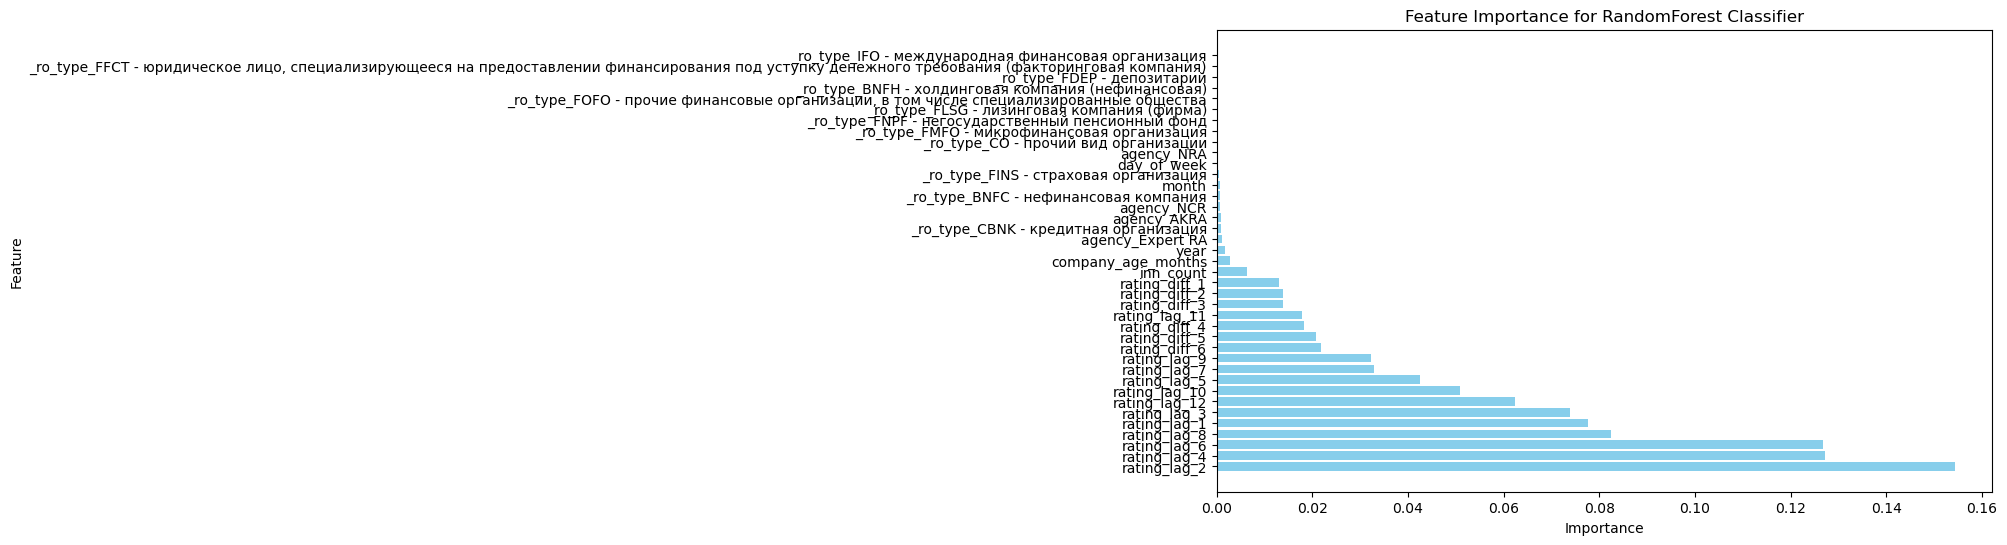

                                              Feature  Importance
28                                       rating_lag_2    0.154314
30                                       rating_lag_4    0.127120
32                                       rating_lag_6    0.126793
34                                       rating_lag_8    0.082490
27                                       rating_lag_1    0.077532
29                                       rating_lag_3    0.073875
38                                      rating_lag_12    0.062356
36                                      rating_lag_10    0.050906
31                                       rating_lag_5    0.042480
33                                       rating_lag_7    0.032923
35                                       rating_lag_9    0.032193
26                                      rating_diff_6    0.021695
25                                      rating_diff_5    0.020647
24                                      rating_diff_4    0.018153
37        

In [456]:
# Получение важности фичей
# Важно, что для извлечения важности нужно обратиться к "classifier" внутри pipeline
importances = pipeline.named_steps['classifier'].feature_importances_

# Получаем список всех фичей (категориальные и числовые)
all_features = (pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features).tolist() + numerical_features)
# all_features = numerical_features
# Создание DataFrame для отображения важности фичей
feature_importances = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
})

# Сортировка фичей по важности
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# --- График важности фичей ---
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for RandomForest Classifier')
plt.show()

# Выводим важность фичей
print(feature_importances)

In [457]:
len(data[inn].unique())

1176

Предсказания:

In [459]:
def predict_next_rating(model, last_rows: pd.DataFrame) -> int:
    # Сортировка по дате
    last_rows = last_rows.sort_values("resampled_dates")
    
    # Вычисление разницы рейтинга
    diffs = last_rows[num_].diff().fillna(0)
    
    # Разница по рейтингу для нескольких периодов
    rating_diff_1 = diffs.iloc[-1]
    rating_diff_2 = diffs.iloc[-2] if len(diffs) > 1 else 0
    rating_diff_3 = diffs.iloc[-3] if len(diffs) > 2 else 0
    rating_diff_4 = diffs.iloc[-4] if len(diffs) > 3 else 0
    rating_diff_5 = diffs.iloc[-5] if len(diffs) > 4 else 0
    rating_diff_6 = diffs.iloc[-6] if len(diffs) > 5 else 0
    rating_diff_7 = diffs.iloc[-7] if len(diffs) > 6 else 0
    rating_diff_8 = diffs.iloc[-8] if len(diffs) > 7 else 0
    rating_diff_9 = diffs.iloc[-9] if len(diffs) > 8 else 0
    
    last_date = pd.to_datetime(last_rows["resampled_dates"].iloc[-1])
    start_date = pd.to_datetime(last_rows["resampled_dates"].min())
    year = last_date.year
    month = last_date.month + 1 if last_date.month < 12 else 1
    day_of_week = (last_date + pd.DateOffset(months=1)).dayofweek

    # Вычисление возраста компании
    company_age = (last_date.year - start_date.year) * 12 + (last_date.month - start_date.month)

    # Вычисление месяцев с начала
    months_since_start = company_age  # Это можно доработать, если нужна более точная формула

    # Лаги рейтинга
    rating_lag_1 = last_rows[num_].iloc[-2] if len(last_rows) > 1 else 0
    rating_lag_2 = last_rows[num_].iloc[-3] if len(last_rows) > 1 else 0
    rating_lag_3 = last_rows[num_].iloc[-4] if len(last_rows) > 3 else 0
    rating_lag_4 = last_rows[num_].iloc[-5] if len(last_rows) > 1 else 0
    rating_lag_5 = last_rows[num_].iloc[-6] if len(last_rows) > 1 else 0
    rating_lag_6 = last_rows[num_].iloc[-7] if len(last_rows) > 6 else 0
    rating_lag_7 = last_rows[num_].iloc[-8] if len(last_rows) > 1 else 0
    rating_lag_8 = last_rows[num_].iloc[-9] if len(last_rows) > 1 else 0
    rating_lag_9 = last_rows[num_].iloc[-10] if len(last_rows) > 9 else 0
    rating_lag_10 = last_rows[num_].iloc[-11] if len(last_rows) > 10 else 0
    rating_lag_11 = last_rows[num_].iloc[-12] if len(last_rows) > 11 else 0
    rating_lag_12 = last_rows[num_].iloc[-13] if len(last_rows) > 12 else 0
    rating_lag_24 = last_rows[num_].iloc[-25] if len(last_rows) > 24 else 0
    rating_lag_36 = last_rows[num_].iloc[-37] if len(last_rows) > 36 else 0
    rating_lag_48 = last_rows[num_].iloc[-49] if len(last_rows) > 48 else 0
    # Дополнительная информация
    inn_count = len(last_rows)
    row = last_rows.iloc[-1]
    
    # Создание входных данных для модели
    input_data = pd.DataFrame([{
        'rating_diff_1': rating_diff_1,
        'rating_diff_2': rating_diff_2,
        'rating_diff_3': rating_diff_3,
        'rating_diff_4': rating_diff_4,
        'rating_diff_5': rating_diff_5,
        'rating_diff_6': rating_diff_6,
        # 'rating_diff_7': rating_diff_7,
        # 'rating_diff_8': rating_diff_8,
        # 'rating_diff_9': rating_diff_9,
        'year': year,
        'month': month,
        'day_of_week': day_of_week,
        'inn_count': inn_count,
        'company_age_months': company_age,  # Возраст компании
        'rating_lag_1': rating_lag_1,
        'rating_lag_2': rating_lag_2,
        'rating_lag_3':rating_lag_3,
        'rating_lag_4': rating_lag_4,
        'rating_lag_5': rating_lag_5,
        'rating_lag_6':rating_lag_6,
        'rating_lag_7': rating_lag_7,
        'rating_lag_8': rating_lag_8,
        'rating_lag_9':rating_lag_9,
        'rating_lag_10': rating_lag_10,
        'rating_lag_11': rating_lag_11,
        'rating_lag_12': rating_lag_12,
        # 'rating_lag_24':rating_lag_24,
        # 'rating_lag_36':rating_lag_36,
        # 'rating_lag_48':rating_lag_48,
        agency: row[agency],
        _ro_type: row[_ro_type]  # Добавление _ro_type
    }])


    return model.predict(input_data)[0]

In [460]:
def forecast_k_steps(model, last_rows: pd.DataFrame, k: int) -> list:
    predictions = []

    for _ in range(k):
        # Прогноз одного шага
        next_rating = predict_next_rating(model, last_rows)
        predictions.append(next_rating)

        # Обновим временной ряд, чтобы использовать для следующего шага
        last_date = pd.to_datetime(last_rows[date].iloc[-1])
        next_date = last_date + pd.DateOffset(months=1)  # шаг = 1 месяц

        new_row = last_rows.iloc[-1].copy()
        new_row[date] = next_date
        new_row[num_] = next_rating
        last_rows = pd.concat([last_rows, pd.DataFrame([new_row])], ignore_index=True)

    return predictions


In [461]:
import random
company_inn = random.choice(list(data[inn].unique()))  # Пример
last_rows = data[data[inn] == company_inn].drop(columns=['Unnamed: 0', 'rating_category', 'identifier']).tail(24)  # Последние 5 записей для компании
print(last_rows.columns)
last_rows = last_rows.sort_values("resampled_dates")
missing = set(X_test.columns) - set(last_rows.columns)
print(missing)
# input_features = last_rows[X_test.columns]  # только нужные признаки
predicted_rating = predict_next_rating(pipeline, last_rows)
print(f"Прогнозируемый рейтинг для компании {company_inn}: {predicted_rating}")
print(len(data[inn].unique()))

Index(['agency', '_ro_type', 'resampled_dates', 'resampled_values',
       'rating_diff_1', 'rating_diff_2', 'rating_diff_3', 'rating_diff_4',
       'rating_diff_5', 'rating_diff_6', 'rating_diff_7', 'rating_diff_8',
       'rating_diff_9', 'rating_lag_12', 'rating_lag_24', 'rating_lag_36',
       'rating_lag_48', 'year', 'month', 'day_of_week', 'inn_count',
       'company_age_months', 'rating_lag_1', 'rating_lag_2', 'rating_lag_3',
       'rating_lag_4', 'rating_lag_5', 'rating_lag_6', 'rating_lag_7',
       'rating_lag_8', 'rating_lag_9', 'rating_lag_10', 'rating_lag_11'],
      dtype='object')
set()
Прогнозируемый рейтинг для компании 7704465140: 3
1176


In [462]:
forecast_24 = forecast_k_steps(pipeline, last_rows, k=24)

In [463]:
forecast_24

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [464]:
last_rows

,agency,_ro_type,resampled_dates,resampled_values,rating_diff_1,rating_diff_2,rating_diff_3,rating_diff_4,rating_diff_5,rating_diff_6,...,rating_lag_2,rating_lag_3,rating_lag_4,rating_lag_5,rating_lag_6,rating_lag_7,rating_lag_8,rating_lag_9,rating_lag_10,rating_lag_11
85999,AKRA,FINS - страховая организация,2022-12-31,3,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
86000,AKRA,FINS - страховая организация,2023-01-31,3,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
86001,AKRA,FINS - страховая организация,2023-02-28,3,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
86002,AKRA,FINS - страховая организация,2023-03-31,3,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
86003,AKRA,FINS - страховая организация,2023-04-30,3,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
86004,AKRA,FINS - страховая организация,2023-05-31,3,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
86005,AKRA,FINS - страховая организация,2023-06-30,3,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
86006,AKRA,FINS - страховая организация,2023-07-31,3,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
86007,AKRA,FINS - страховая организация,2023-08-31,3,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
86008,AKRA,FINS - страховая организация,2023-09-30,3,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [477]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
import pandas as pd

def evaluate_model(model, data, window_sizes=[3, 6, 12, 24]):
    """
    Функция для оценки модели с использованием различных окон (window_sizes).
    Она будет делать прогнозы для каждого окна, сравнивать их с реальными значениями
    и вычислять различные метрики точности.
    """
    inn = 'identifier'
    date = 'resampled_dates'
    num_ = 'resampled_values'
    category = 'rating_category'
    agency = 'agency'
    _ro_type = '_ro_type'
    results = {}
    
    for window in window_sizes:
        y_true = []
        y_pred = []
        
        # Прогнозирование для каждого инн (компании)
        counter = 1
        for inn_ in data[inn].unique():
            company_data = data[data[inn] == inn_].sort_values(date)
            
            # Прогнозирование по последним N месяцам для каждого окна
            for i in range(window, len(company_data)):
                last_rows = company_data.iloc[i - window:i]
                true_rating = company_data[num_].iloc[i]  # Реальный рейтинг
                
                # Прогнозируем следующий рейтинг
                predicted_rating = predict_next_rating(model, last_rows)
                
                y_true.append(true_rating)
                y_pred.append(predicted_rating)
            print(inn_, counter, len(data[inn].unique()))
            counter += 1
        # В зависимости от типа задачи, можем использовать разные метрики:
        # Преобразуем рейтинги в числа, если они категориальные
        # y_true_numeric = [ratings.index(rating) for rating in y_true]
        # y_pred_numeric = [ratings.index(rating) for rating in y_pred]
        y_true_numeric = y_true
        y_pred_numeric = y_pred
        # Вычисление метрик
        accuracy = accuracy_score(y_true_numeric, y_pred_numeric)
        precision = precision_score(y_true_numeric, y_pred_numeric, average='macro', zero_division=0)
        recall = recall_score(y_true_numeric, y_pred_numeric, average='macro', zero_division=0)
        f1 = f1_score(y_true_numeric, y_pred_numeric, average='macro', zero_division=0)
        mae = mean_absolute_error(y_true_numeric, y_pred_numeric)

        results[window] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'mae': mae
        }
    print(results)
    return results

# Пример использования функции:
window_sizes = [12, 24, 36, 48]  # Размеры окон для прогноза
results = evaluate_model(pipeline, data, window_sizes)

# Печать результатов для каждого окна
for window, metrics in results.items():
    print(f"Window size: {window} months")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print("="*30)


103001895 1 1176
106000547 2 1176
268008010 3 1176
272901636 4 1176
274045684 5 1176
274051582 6 1176
274062111 7 1176
275031814 8 1176
275913140 9 1176
276016368 10 1176
278128444 11 1176
278181110 12 1176
411006129 13 1176
411137185 14 1176
541012405 15 1176
541016015 16 1176
602017266 17 1176
901000990 18 1176
901001063 19 1176
917014928 20 1176
1001011328 21 1176
1101300820 22 1176
1102011300 23 1176
1105001927 24 1176
1300034972 25 1176
1326021671 26 1176
1326024785 27 1176
1402046014 28 1176
1402047184 29 1176
1433000147 30 1176
1433009894 31 1176
1434045743 32 1176
1435001668 33 1176
1435032049 34 1176
1435126628 35 1176
1435133520 36 1176
1435138944 37 1176
1435159327 38 1176
1435175512 39 1176
1435241444 40 1176
1435332211 41 1176
1435333590 42 1176
1615013655 43 1176
1627000724 44 1176
1644001196 45 1176
1644003838 46 1176
1644004905 47 1176
1644039560 48 1176
1650002455 49 1176
1650014919 50 1176
1650025163 51 1176
1650032058 52 1176
1650072068 53 1176
1650249702 54 1176
165